# Assignment 2

The dataset we will be using in this assignment is the sunspots dataset made available by [SILSO](http://sidc.be/silso/home), Sunspot Index and Long-term Solar Observations, by the Royal Observatory in Belgium. The dataset is shared under the [CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/) license. We have made no changes to the original dataset but you only work with a few columns of the data.

The dataset consists of the monthly mean number of sunspots on the sun, dating back to January 1749.
Our goal in this assignment is to make a time-series model to predict the number of sunspots next month.
The structure of the assignment is very similar to the 05a notebook, it consists of the following steps.

1. Read dataset and make a simple plot.
1. Create training and testing sequences.
1. Split the dataset into train/test.
1. Scale the dataset using the min/max approach (unlike 05a notebook).
1. Create an RNN which uses a single recurrent layer (SimpleRNN, GRU or LSTM) and then a regression layer.
1. Predict the monthly mean number of sunspots for April 2019.

Doing all of these steps sufficiently well in addition to getting low enough loss, will give you a score of 1. At this stage you are not allowed to change the sequence length used to train and test. All other hyperparameters are up to you, including the loss function.

To receive a score of 2 you will need to do further improvements to your model. You will need to achieve a lower test score **and** apply **two** (or more) of the following techniques.
1. Make the RNN stateful.
1. Apply (input/recurrect/normal) dropout.
1. Add dense layers after the recurrent layer.
1. Stack multiple GRUs.
1. Adjust the sequence length.

First we start by loading the required libraries. In the `assignment-2-helpers.R` you will find the following functions `split_dataset <- function(x_data, y_data, fraction = 0.2)` which we used in the 05a notebook to split our dataset into train/test datasets. You will also find the function `create_sequences_x_y <- function(data, sequence_length, target_shift, step_shift)` which we used to generate the sequences. Lastly, you will find the function `load_sunspots_dataset <- function()` to load the dataset.

The `create_sequences_x_y` and `split_dataset` are optional functions and you can use them, but you do not need to.

In [1]:
library(keras)
library(ggplot2)
source("assignment-2-helpers.R")

use_multi_cpu(2L)
# This specifies the number of threads TensorFlow will use. You can change this number, 
# but it depends on the model, what the optimal number of threads might be.
# In my experiments 2 threads performed quite well for simpleRNNs.
# Using more than 2 threads increased communication overhead between CPUs and decreased the training speed.
# To change this value simply set the value which you want and then -
# click "Kernel" -> "Shutdown" and then "Kernel" -> "Restart".
# If you do not shutdown the kernel, the change will not take effect.

## 1. Read data and plot
## 1.1 Read data
In the cell below load the dataset by calling the function `load_sunspots_dataset()`. Explore the columns and check the dimensions of the dataset. What are the dimensions of the dataset? It is sufficient to print the number out.

In [2]:
data <- load_sunspots_dataset()
dim(data)

[1] 3243    3

## 1.2 Plot the data
In the cell below plot the `Mean monthly sunspots`. You can use the plot function you want to.

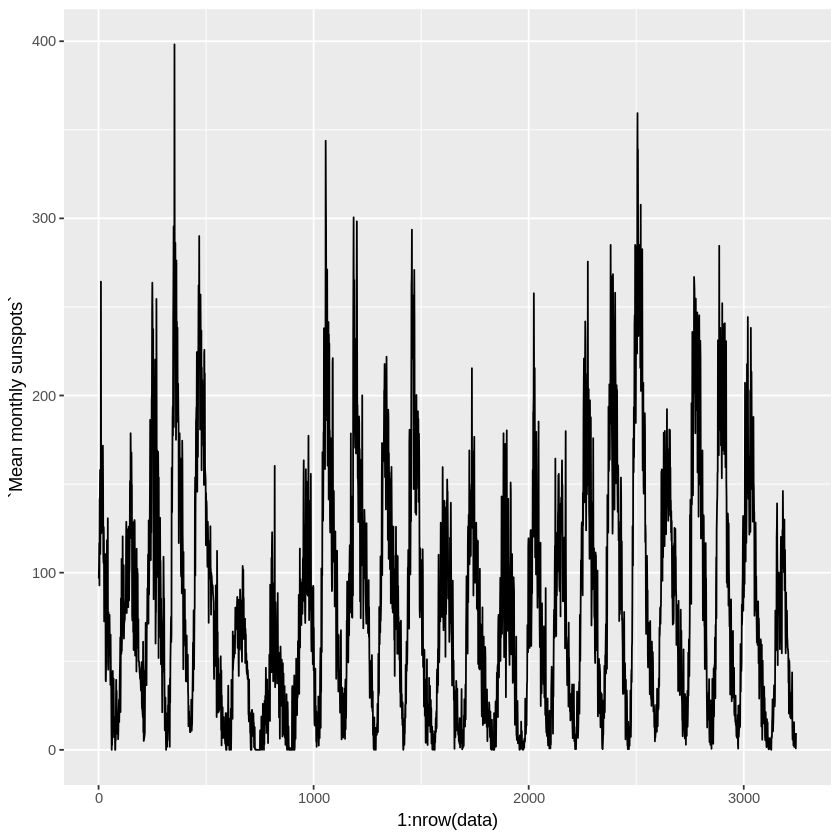

In [3]:
ggplot(data, aes(x = 1:nrow(data),y=`Mean monthly sunspots`)) + geom_line()

## 1.3 Find the cycle
From the plot we want to see how many timesteps it takes for the cyclic pattern to repeate it self. From the plot how many timesteps, circa, does each cycle have? Write your answer in the cell below.

**Answer**: the cycle is around 11 years long.

## 2. Creating sequences
Now we want to create the sequences which we will then use to train and test our model. We will not use all features of the data to create the sequences, but only the monthly mean number of sunspots.
## 2.1 Eliminate all extra features from the data

In [4]:
sunspot_data = data[,3]

## 2.2 Create sequences
Given the monthly mean number of sunspots create sequences with sequence length of 100. Feel free to use the `create_sequences_x_y` function.

For each sequence, the target value should be the next month's monthly mean number of sunspots. That is, if the last element in our sequence is the sunspot number for March 2019, we want our target to be number of sunspots for April 2019 (the value for April 2019 is not in the data but March 2019 is). If you change the sequence length, do not change the `target_shift` (if you use `create_sequences_x_y`).

The `step_shift` is up to you.

This is a sequence length is very close to the observed cycles in the data. We leave it up to you to experiment with different sequence lengths for extra points.

In [5]:
sequence_data <- create_sequences_x_y(data = sunspot_data, sequence_length = 110, target_shift = 0, step_shift = 1)
dim(sequence_data$x)
dim(sequence_data$y)

[1] 3133  110    1

[1] 3133    1

**NOTE**: the `target_shift` should be set to 0, which will take the month just after as its target. A target shift of 1 would have the target two months in advance.

## 3. Splitting
Now we must split our dataset into train/test. Feel free to use the `split_dataset` function for this. Remember that the function returns a list containing `x_train`, `y_train`, `x_test` and `y_test`.
## 3.1 Split to train/test
Split the dataset into train/test. Make sure that test set contains sequences which are **after** the training set. The test set should contain 20% of the sequences from the whole dataset. 

In [6]:
split_data <- split_dataset(x_data = sequence_data$x, y_data = sequence_data$y, fraction = 0.2)

x_train = split_data$x_train
y_train = split_data$y_train
x_test = split_data$x_test
y_test = split_data$y_test

dim(x_train)
length(y_train)
dim(x_test)
length(y_test)

[1] 2506  110    1

[1] 2506

[1] 627 110   1

[1] 627

## 4. Scaling
To help our network train faster, we need to **scale** our data. In this assignment we will scale our data using the Min/Max approach, the same approach as we did for pixel values. 

We will not use the **normalisation** approach since we do not expect our data to be normally distributed. Up to this point we have not been precise in class and called both approaches "scaling" when in fact **normalisation** is scaling by the mean and standard deviation and assumes that our data is normally distributed. This is not the case now and we will scale the data so that the largest value in our training data will have value `1` and the smallest value will have the value `0`. To achieve this we do:

$$
x' = \frac{x - \min(\boldsymbol{x})}{\max(\boldsymbol{x}) - \min(\boldsymbol{x})}
$$

Where $x$ is a single example and $x'$ is our new scaled value. $\min(\boldsymbol{x})$ is the smallest value in the training set and $\max(\boldsymbol{x})$ is the largest value.
For the interested we recommend the [wikipedia article](https://en.wikipedia.org/wiki/Feature_scaling).

## 4.1 Calculate the max and min
Calculate the max and min of the monthly mean sunspots over the training data.

In [7]:
min <- min(x_train)
max <- max(x_train)
min
max

[1] 0

[1] 398.2

## 4.2 Scale the training and test data
Scale the training and test data using the Min/Max scaling approach defined above. Your implementation of the scaling approach does not have to look like the formula above but it needs to have the same effect. Do not scale the targets.

In [8]:
x_train_scaled <- x_train/max
x_test_scaled <- x_test/max

In [9]:
x_train_scaled[1,1,1]

[1] 0.2428428

## 5. The baseline model
In this section you will implement a baseline timeseries model. To achieve a score of `1` for the assignment you only need to implement the baseline model and achieve the following test scores.
- Using "mae" loss you need to have test loss lower than `30`
- Using "mse" loss you need to have test loss lower than `2000`

You should use a Simple RNN, GRU or an LSTM layer in your model and after that layer you should implement a regression layer. Besides these requirements we leave the rest of the model definition and hyperparameter selection up to you.

## 5.1 Baseline model
Implement a model based on the description above.

**Hint** To speed up training it is helpful to remove the `callbacks=list(Progress$new())` line from the `fit` function. The side-effect is that you have less idea of how far in the training process you are, but you can be sure that it is about 1/5 faster.

**Answer**: below is an example model. Your model can look different.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru (GRU)                           (None, 8)                       240         
________________________________________________________________________________
dense (Dense)                       (None, 1)                       9           
Total params: 249
Trainable params: 249
Non-trainable params: 0
________________________________________________________________________________


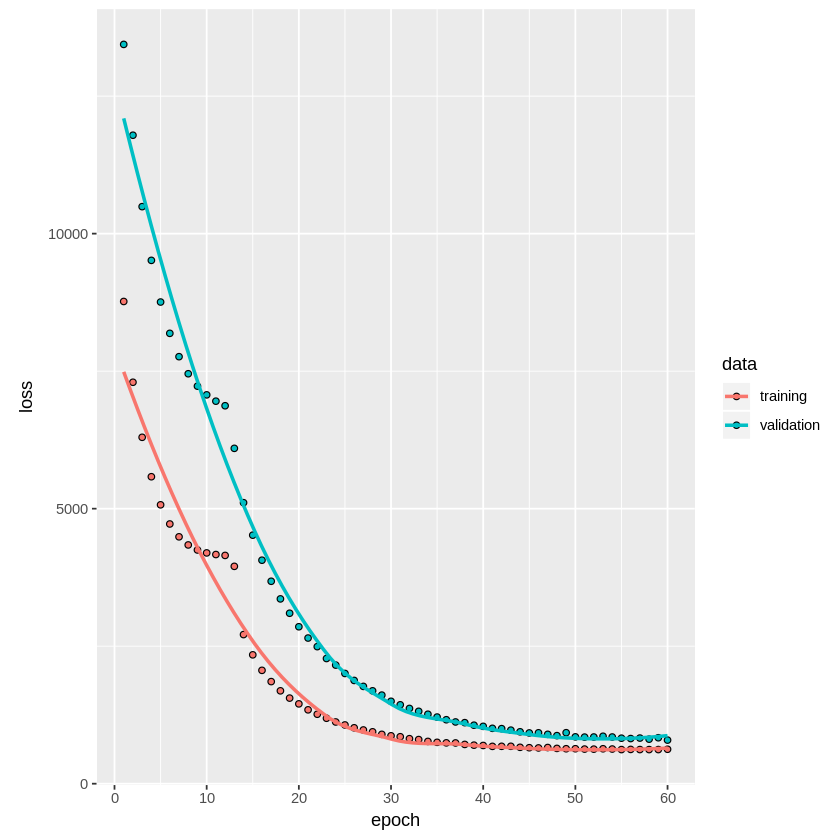

In [10]:
model <- keras_model_sequential() %>%
    layer_gru(units = 8, input_shape = c(110, 1)) %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "mse"
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    validation_split = 0.2,
    epochs = 60,
    batch_size = 16,
    callbacks=list(Progress$new())
)

plot(history)

When you finished tuning your model evaluate your model and report the loss over the test set. Methodologically, you should only evaluate your once (or not very often). Try to keep to that convention.

## 5.2 Evaluate the model
Evaluate your model and report the loss over the test dataset.

In [11]:
model %>% evaluate(x_test_scaled, y_test)

loss 
536.1011

## 5.3 Predict the monthly mean number of sunspots for April 2019
Now we will use our baseline model to predict the monthly mean number of sunpots for April 2019. This requires you to use the `predict` function exposed by Keras. We used this function in notebook 05a.

You will need to manually create the correct sequence. The sequence will need to have the same sequence length as we used to train the model. To feed it to the network it will need to have dimensions `(1, 50, 1)`, to achieve this create and array like this: `array(your_sequence, dim = c(1, 50, 1))`. This will correctly shape the data when you have extracted the correct sequence, `your_sequence`.

**Hint** It is probably best to go all the way back to the cleaned data from excercise 2.1 and create the sequence from there. Do not forget to scale it.

In [15]:
sequence <- sunspot_data[(length(sunspot_data) - 109):length(sunspot_data)]
sequence <- sequence/max
sequence <- array(sequence, dim = c(1, 110, 1))
prediction <- model %>% predict(sequence)
prediction

9.452275


## 6 Improving the model
Below you can try to improve the model you created in section 5.
Feel free to add cells by clicking "Insert -> Insert Cell Below/Above".

To get a score of `2` for this assignment you will need to
- get "mae" loss below `18` or 
- get "mse" loss below `600` on the test set

**and do two** of the following.
1. Make the RNN stateful.
1. Apply (input/recurrect/normal) dropout.
1. Add dense layers after the recurrent layer.
1. Stack multiple GRUs.
1. Adjust the sequence length.

**Answer**: we have opted for a model with a shorter sequence length (30 instead of 100), and a stacked GRU. We have found that stacked GRUs provide a reliable way of reaching the performance threshold. Adding dense layers can work as well, but we have found them quite tricky to tune without any recurrent components. Dropout and L2-regularisation can help in stabilising the convergence, although for stacked GRUs this is not really a problem.

In [16]:
sequence_length <- 30
sequence_data <- create_sequences_x_y(data = sunspot_data, 
                                      sequence_length = sequence_length, 
                                      target_shift = 0, 
                                      step_shift = 1)
split_data <- split_dataset(x_data = sequence_data$x, y_data = sequence_data$y, fraction = 0.2)

x_train = split_data$x_train
y_train = split_data$y_train
x_test = split_data$x_test
y_test = split_data$y_test
x_train_scaled <- x_train/max
x_test_scaled <- x_test/max

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
gru_1 (GRU)                         (None, 30, 8)                   240         
________________________________________________________________________________
gru_2 (GRU)                         (None, 8)                       408         
________________________________________________________________________________
dense_1 (Dense)                     (None, 1)                       9           
Total params: 657
Trainable params: 657
Non-trainable params: 0
________________________________________________________________________________


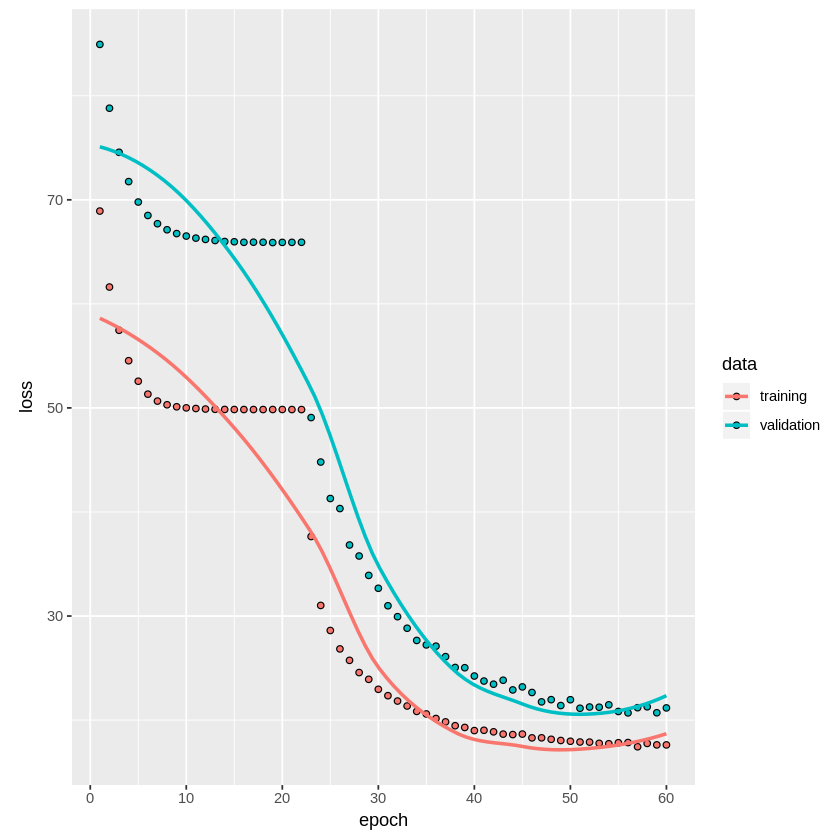

In [17]:
batch_size = 16
model <- keras_model_sequential() %>%
    layer_gru(units = 8,
              input_shape = c(sequence_length, 1),
             return_sequences = TRUE) %>%
    layer_gru(units = 8,
          input_shape = c(sequence_length, 1)) %>%
    layer_dense(units = 1)

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.01),
    loss = "mae"
)

history <- model %>% fit(
    x = x_train_scaled,
    y = y_train,
    validation_split = 0.2,
    epochs = 60,
    batch_size = batch_size,
    callbacks=list(Progress$new())
)

plot(history)

In [18]:
model %>% evaluate(x_test_scaled, y_test)

loss 
17.21483